In [1]:
%matplotlib inline
import torch 
import torchvision
from torchvision.datasets import FashionMNIST
import torch.nn as nn
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
# from vis_utils import *
import random
import math
import matplotlib.pyplot as plt
import image
from IPython.display import display
import time

In [2]:
num_epochs = 5;
batch_size = 1000;
learning_rate = 0.001;
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'Using device: {torch.cuda.get_device_name(0)}')
else:
    print(f'Using device: CPU')
    
data_folder = 'data/'
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

Using device: GeForce GTX 1060 6GB


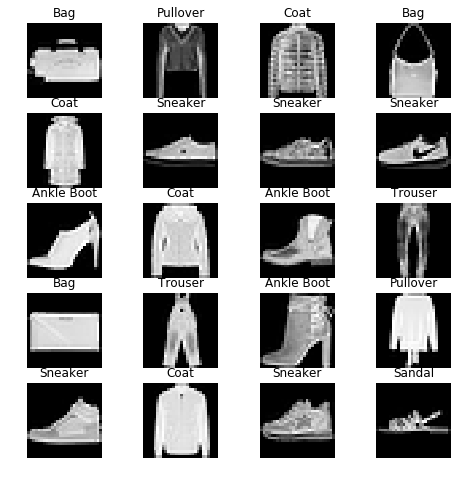

In [3]:
training_data = FashionMNIST(data_folder, train=True, download=True)

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(training_data));
    img = training_data[img_xy][0]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[training_data[img_xy][1].item()])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [86]:
print('Downloading and transforming data')
pre_process_training = transforms.Compose([
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(20),
    transforms.ToTensor()
    ])

pre_process_test = transforms.Compose([
    # transforms.RandomCrop(20),
    transforms.ToTensor()
    ])

training_data = FashionMNIST(data_folder, train=True, download=True, transform=pre_process_training)
validation_data = FashionMNIST(data_folder, train=False, download=True, transform=pre_process_test)

training_data_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4)
validation_data_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=4)


In [99]:
# zero padding = (filter_size - 1)/2
# output from CNN = (input_size - filter_size + 2*padding)/stride +1

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Linear(7*7*32, 200),
            nn.Linear(200, 10))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.layer3(out)
        return out
    
    
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Linear(7*7*32, 200)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook



In [103]:
print('Starting training')
start_time = time.time()
network = CNN3()
network.to(device)
network.fc1.register_forward_hook(get_activation('fc1'))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

nbr_iterations = len(training_data)//batch_size
losses = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(training_data_loader):
        images = Variable(images.float()).to(device)
        labels = Variable(labels).to(device)
        
        optimizer.zero_grad()
        outputs = network(images)
        print(activation['fc1'].size(0), activation['fc1'].size(1))
        break
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        current_loss = loss.data.item()
        losses.append(current_loss)
        
        if((i+1) % 100 == 0):
            print(f'Epoch: {epoch+1}/{num_epochs}, Iteration: {i+1}/{nbr_iterations}, Loss: {round(current_loss, 2)}')
            
print(f'Done after {round((time.time() - start_time)/60, 2)}min')

Starting training
1000 200
1000 200
1000 200
1000 200
1000 200
Done after 0.03min


In [95]:
network.eval()
correct = 0
total = 0
for images, labels in validation_data_loader:
    images = Variable(images.float()).to(device)
    labels = labels.to(device)
    outputs = network(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print(f'Validation accuracy on 10 000 images: {round(correct.item()/total, 2)}')

Validation accuracy on 10 000 images: 0.89


/home/victor/Projects/private/fashion-mnist/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


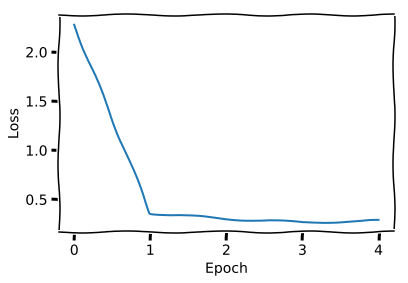

In [21]:
losses_in_epochs = losses[0::nbr_iterations]
plt.xkcd()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses_in_epochs)
plt.show()

In [97]:
class EmbeddingCNN(nn.Module):
    def __init__(self):
        super(EmbeddingCNN, self).__init__()
        
        self.features = nn.Sequential(
            *list(network.features.children())[:-1]
        )
    def forward(self, x):
        out = self.features(x)
        return x
    
embedding_network = EmbeddingCNN()
embedding_network.eval()
for images, labels in validation_data_loader:
    images = Variable(images.float()).to(device)
    labels = labels.to(device)
    outputs = network(images)
    
    print(outputs.size(0), outputs.size(1))
    print(outputs.data)
    
    break

AttributeError: 'CNN3' object has no attribute 'features'